In [1]:
# Dubbi:
#1 come mai le chiavi di a sembrano random?
#2 come faccio a non fare re-inserimento ?? Ricorda io estraggo d-1 cosi, più uno, più un altro che è quello di arrivo

In [3]:
import OffsetArrays
using Plots
using Revise
using ProgressMeter
using SparseArrays, LinearAlgebra, IndexedGraphs, Graphs
srcpath = "../src"
include("$srcpath/functions.jl")

rand_disorder (generic function with 1 method)

In [3]:
# S=0   I=1
# The times go from ti = 0 to ti=T+1
# when ti=0 it means that i is the zero patient
# when ti=T+1 it means that i is never infected

λp = 0.6 # planted infection rate
λi = 0.6 # inferred infection rate

d = 3 # degree (fixed for now) 
T = 4 # discrete time

γp = 0.1 # planted autoinfection probability
γi = 0.1 # inferred autoinfection probability

N = 5000; #population size

# Population dynamics for the messages

In [4]:
# Creation of the population
# we create μ as the set of all the N functions
# μ[k,ti,ck,τi,σk] is the value taken by the
# function μk with arguments ti,ck,τi,σk
# Using OffsetArrays we managed to keep notation 
# coherent with the notes: 

# i=1,...,N, 
# ti=0,...,T+1 
# c = 0,1
# σ=0,1,2

# The same is done for the ν function later
inizialization = ones(N,T+2,2,T+2,3) / (6*(T+2)^2)
μ = OffsetArrays.OffsetArray(inizialization,0,-1,-1,-1,-1);

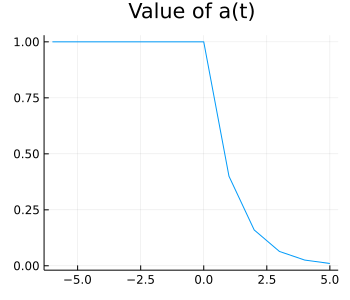

In [5]:
#Precalculation of the function a := (1-λ)^{tθ(t)}, 
#useful for later (the function a appears
#  in the inferred time factor node)

a = Dict(zip(-T-2:T+1,[ t<=0 ? 1 : (1-λi)^t for t = -T-2:T+1]));
μold = copy(μ);
plot(LinRange(-T-2,T+1,2T+4),[a[t] for t=-T-2:T+1],size=(350,300),legend=false,title="Value of a(t)")

In [6]:
ν = OffsetArrays.OffsetArray(zeros(T+2,T+2,T+2,3),-1,-1,-1,-1);
neighbours = rand(1:N,d-1);

In [12]:
tot_iterations = 20000
@showprogress for iterations = 1:tot_iterations
    # Extraction of disorder: state of individual i: xi0, delays: sij and sji

    xi0,sij,sji = rand_disorder(γp,λp)

    # Initialization of ν=0
    ν = OffsetArrays.OffsetArray(zeros(T+2,T+2,T+2,3),-1,-1,-1,-1)

    #Extraction of d-1 μ's from population
    neighbours = rand(1:N,d-1)

    #Beginning of calculations: we start by calculating the ν: 
    calculate_ν!(ν,μ,neighbours,xi0,T,γi,a)
    
    # Now we use the ν vector just calculated to extract the new μ.
    # We extract a population index that we call "l".
    # We overwrite the μ in postition μ[l,:,:,:,:]
    l = rand(1:N);

    # First we calculate and store the cumulated of ν with respect to 
    # planted time, i.e. the third argument. We call Σ this cumulated 
    Σ = cumsum(ν,dims=3)
    update_μ!(μ,ν,Σ,l,sij,sji,T)     
end

#p1=plot(reshape(sum(μ,dims=1) ./ N,864))
#p1=plot!(reshape(sum(μold,dims=1) ./ N,864))
#μold = copy(μ);
#plot(p1)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


We plot the heatmaps of the messages

# From messages to marginals

In [13]:
p = OffsetArrays.OffsetArray(zeros(T+2,T+2,T+2),-1,-1,-1);
marg = OffsetArrays.OffsetArray(zeros(N,T+2,T+2),0,-1,-1);
max_count = N;

In [98]:
# Now we take out converged population of μ and use it to extract marginals.
# First we extract two ν's and then we combine it in order to obtain a marginal.
# In order to extract a ν we have to extract d-1 μ's. Therefore we extract two groups of 
# d-1 μ's and from them we calculate the two ν's. We also have to extract disorder.
@showprogress for l = 1:max_count
    group1 = rand(1:N,d-1) #groups of neighbours 
    group2 = rand(1:N,d-1)
    
    xi0,sij,sji = rand_disorder(γp,λp) #planted disorder
    xj0 = Int(rand() < γp);
    
    ν1 = OffsetArrays.OffsetArray(zeros(T+2,T+2,T+2,3),-1,-1,-1,-1)
    ν2 = OffsetArrays.OffsetArray(zeros(T+2,T+2,T+2,3),-1,-1,-1,-1)

    calculate_ν!(ν1,μ,group1,xi0,T,γi,a)
    calculate_ν!(ν2,μ,group2,xj0,T,γi,a)

    #Once the ν are calculated we have to cumulate with respect the third argument
    Σ = cumsum(ν2,dims=3)
    update_marginal!(marg,l,ν1,ν2,Σ,sij,sji,T)
end
marg2D = reshape((sum(marg,dims=1)./ max_count),T+2,T+2);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


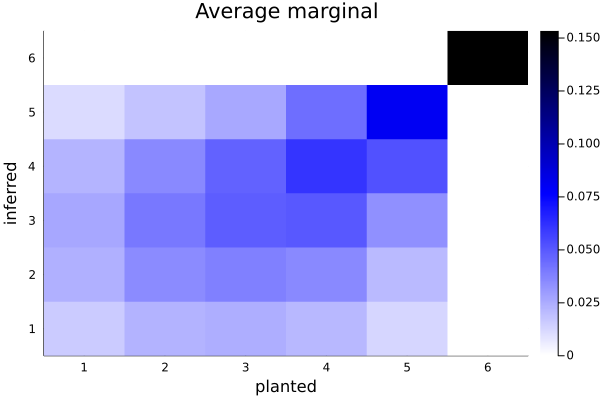

In [99]:
pheat = heatmap((marg2D),c=[:white,:blue,:black],xlabel="planted",ylabel="inferred",title="Average marginal")

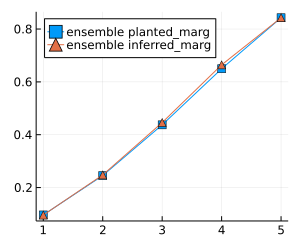

In [16]:
p0 = plot(cumsum(sum(marg2D,dims=1)'[1:end-1],dims=1),marker=:square,label="ensemble planted_marg")
p0 = plot!(cumsum(sum(marg2D,dims=2)[1:end-1],dims=1),marker=:utriangle,label="ensemble inferred_marg",legend=:bottomright)
plot(p0,size=(300,250),legend=:topleft)

# Single Instance Inferernce with Sib

## No disorder
In this regime we don't have disorder, in the sense that the planted distribution is a delta. The planted observation is "all infected"

## General framework with disorder
Here the results of observations change because the parameter regime is non trivial. Therefore we need to sample a planted configuration, observe this configuration at final time and infere the single instance. We do this many times and we average so to compare with the ensemble results

### Check of the planted distribution
Here we check with a sampler and with sibyl that the planted ensemble marginal is correct.

In [4]:
include("$srcpath/sampler.jl")
include("$srcpath/BP.jl")

Ngraph = 2500 # size of the single instance graph
x = zeros(Int,Ngraph, T + 1) # a single epidemic trajectory

# First we initialize a single instance marginal y
# which will be the average over graph and particles
# and epidemic trajectory of the marginals
y = zeros(T+1)
yBP = zero(y)
# we average over totst iterations
totst = 15
@showprogress for st = 1:totst
    # for every iteration we initialize a new graph
    G = random_regular_graph(Ngraph,d) |> IndexedBiDiGraph 
    # we sample an epidemic
    sample!(x, G, λp, γp)
    # we calculate the cumulative marginal (non-normalized)
    # and we sum it to the average marginal
    y .+= sum(x,dims=1)'
    p_sib = sibyl(Ngraph, T+1, G, [], γi, λi; maxit = 40, tol = 1e-2);
    avgmarg = sum(p_sib,dims=1)' ./ Ngraph
    yBP .+= avgmarg
end
#we normalize the average marginal
y ./= (Ngraph * totst)
yBP ./=  totst

LoadError: UndefVarError: T not defined

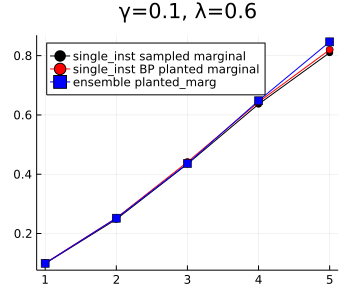

In [119]:
p0 = plot(y,c=:black,marker=:circle,label="single_inst sampled marginal",title="γ=$γp, λ=$λp")
p0 = plot!(yBP,c=:red,marker=:circle,label="single_inst BP planted marginal")
p0 = plot!(cumsum(sum(marg2D,dims=1)'[1:end-1],dims=1),c=:blue,marker=:square,size=(350,300),label="ensemble planted_marg",legend=:topleft)

### Comparison between inference (sibyl) and ensemble results
Here we check instead the results for the inferred marginal

In [120]:
yBP = zeros(T+1)
yBPerr = zero(yBP)
@showprogress for st = 1:totst
    # for every iteration we initialize a new graph
    G = random_regular_graph(Ngraph,d) |> IndexedBiDiGraph 
    # we sample an epidemic
    sample!(x, G, λp, γp)
    # observations set in the form of 
    # [(individual,state,observation time, false_rate of the test)]
    # where state ∈ {0,1} respectively for S and I
    # The reason why there is a T+1 is that sibyl starts from time 1 to time T. 
    # Instead the ensemble goes from time 0 to time T  
    O = [(i,x[i,T+1],T+1,1e-10) for i = 1:Ngraph]
    #we now run the BP algorithm for the single instance defined above
    p_sib = sibyl(Ngraph, T+1, G, O, γi, λi; maxit = 40, tol = 1e-2);
    yBP .+= sum(p_sib,dims=1)'
    yBPerr .+= sum(p_sib ,dims=1)' .^ 2
end

yBP ./= (Ngraph * totst)
yBPerr ./= (Ngraph^2 * totst)
yBPerr .= sqrt.(yBPerr .- yBP .^ 2) / sqrt(totst)


Progress:  93%|██████████████████████████████████████▎  |  ETA: 0:00:01


sib.iterate(damp=0.0): 11/40 9.243e-03/0.01      
sib.iterate(damp=0.5): 0/40 7.985e-03/0.01      
sib.iterate(damp=0.9): 0/40 4.021e-03/0.01      
sib.iterate(damp=0.0): 11/40 8.624e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.382e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.300e-03/0.01      
sib.iterate(damp=0.0): 11/40 9.931e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.877e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.764e-03/0.01      
sib.iterate(damp=0.0): 11/40 9.900e-03/0.01      
sib.iterate(damp=0.5): 0/40 6.587e-03/0.01      
sib.iterate(damp=0.9): 0/40 3.461e-03/0.01      
sib.iterate(damp=0.0): 11/40 6.275e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.813e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.059e-03/0.01      
sib.iterate(damp=0.0): 12/40 4.898e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.846e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.863e-03/0.01      
sib.iterate(damp=0.0): 12/40 8.298e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.436e-03/0.01      
sib.iterate(

Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


5-element Vector{Float64}:
 0.0012677693978411218
 0.0032790099973860434
 0.005242195411641223
 0.006163303904177984
 0.005204287691360531

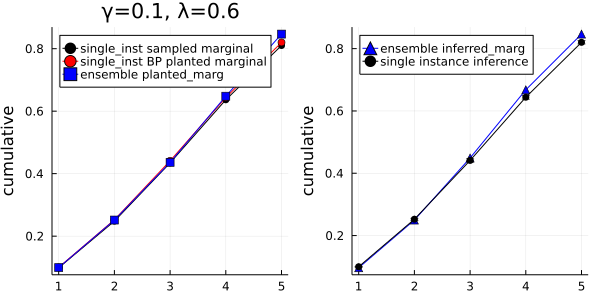

In [121]:
p1 = plot(cumsum(sum(marg2D,dims=2),dims=1)[1:end-1],c=:blue,marker=:utriangle,label="ensemble inferred_marg",legend=:bottomright)
p1 = plot!(yBP,yerr=yBPerr,c=:black,marker=:circle,label="single instance inference")
plot(p0,p1,size=(600,300),ylabel="cumulative",legend=:topleft)
#savefig("sibVSepid")

## 2D marginal comparison

In [100]:
function pdf(cdf_sib)
    N, T = size(cdf_sib) 
    p = zeros(N,T+1)
    p[:,1] .= cdf_sib[:,1]
    for t = 1:T-1
        p[:,t+1] .= cdf_sib[:,t+1] .- cdf_sib[:,t]
    end
    p[:,T+1] .= 1 .- cdf_sib[:,T]
    return p
end

pdf (generic function with 2 methods)

In [122]:
totst = 100
sibylmarg2D = zeros(T+2,T+2)
@showprogress for st = 1:totst
    G = random_regular_graph(Ngraph,d) |> IndexedBiDiGraph 
    sample!(x, G, λp, γp)
    O = [(i,x[i,T+1],T+1,1e-10) for i = 1:Ngraph]
    p_sib = sibyl(Ngraph, T+1, G, O, γi, λi; maxit = 40, tol = 1e-2);
    sib_pdf = pdf(p_sib)    
    tau = T .- sum(x,dims=2) .+ 2; #set of planted times
    for τ = 1:T+2
        sibylmarg2D[:,τ] .+= sum(sib_pdf .* (tau .== τ ),dims=1)' 
    end
end
sibylmarg2D ./= (Ngraph*totst)

Progress:  13%|█████▍                                   |  ETA: 0:00:59


sib.iterate(damp=0.0): 12/40 6.798e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.434e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.217e-03/0.01      
sib.iterate(damp=0.0): 12/40 6.070e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.412e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.054e-03/0.01      
sib.iterate(damp=0.0): 13/40 6.723e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.044e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.878e-03/0.01      
sib.iterate(damp=0.0): 11/40 8.900e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.980e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.621e-03/0.01      
sib.iterate(damp=0.0): 11/40 9.903e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.394e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.697e-03/0.01      
sib.iterate(damp=0.0): 11/40 7.579e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.704e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.734e-03/0.01      
sib.iterate(damp=0.0): 11/40 8.026e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.021e-03/0.01      
sib.iterate(

Progress:  28%|███████████▌                             |  ETA: 0:00:48


sib.iterate(damp=0.0): 11/40 8.796e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.117e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.163e-03/0.01      
sib.iterate(damp=0.0): 11/40 9.645e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.310e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.312e-03/0.01      
sib.iterate(damp=0.0): 11/40 8.232e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.485e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.264e-03/0.01      
sib.iterate(damp=0.0): 12/40 7.424e-03/0.01      
sib.iterate(damp=0.5): 0/40 6.030e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.576e-03/0.01      
sib.iterate(damp=0.0): 12/40 9.950e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.056e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.516e-03/0.01      
sib.iterate(damp=0.0): 11/40 9.896e-03/0.01      
sib.iterate(damp=0.5): 1/40 6.566e-03/0.01      
sib.iterate(damp=0.9): 0/40 3.496e-03/0.01      
sib.iterate(damp=0.0): 11/40 6.945e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.399e-03/0.01      
sib.iterate(

Progress:  43%|█████████████████▋                       |  ETA: 0:00:38


sib.iterate(damp=0.0): 12/40 7.639e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.329e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.950e-03/0.01      
sib.iterate(damp=0.0): 12/40 7.307e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.751e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.807e-03/0.01      
sib.iterate(damp=0.0): 11/40 6.623e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.349e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.668e-03/0.01      
sib.iterate(damp=0.0): 12/40 4.761e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.363e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.189e-03/0.01      
sib.iterate(damp=0.0): 11/40 8.096e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.239e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.592e-03/0.01      
sib.iterate(damp=0.0): 11/40 6.798e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.928e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.502e-03/0.01      
sib.iterate(damp=0.0): 11/40 9.491e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.750e-03/0.01      
sib.iterate(

Progress:  58%|███████████████████████▊                 |  ETA: 0:00:28


sib.iterate(damp=0.0): 12/40 8.192e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.633e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.768e-03/0.01      
sib.iterate(damp=0.0): 11/40 9.377e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.882e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.815e-03/0.01      
sib.iterate(damp=0.0): 12/40 6.107e-03/0.01      
sib.iterate(damp=0.5): 0/40 6.882e-03/0.01      
sib.iterate(damp=0.9): 0/40 3.161e-03/0.01      
sib.iterate(damp=0.0): 12/40 4.645e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.606e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.821e-03/0.01      
sib.iterate(damp=0.0): 11/40 8.437e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.403e-03/0.01      
sib.iterate(damp=0.9): 0/40 3.209e-03/0.01      
sib.iterate(damp=0.0): 11/40 9.385e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.698e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.530e-03/0.01      
sib.iterate(damp=0.0): 11/40 9.480e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.886e-03/0.01      
sib.iterate(

Progress:  73%|█████████████████████████████▉           |  ETA: 0:00:18


sib.iterate(damp=0.0): 11/40 7.380e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.814e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.413e-03/0.01      
sib.iterate(damp=0.0): 13/40 6.129e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.157e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.079e-03/0.01      
sib.iterate(damp=0.0): 11/40 7.213e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.498e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.126e-03/0.01      
sib.iterate(damp=0.0): 11/40 8.591e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.859e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.258e-03/0.01      
sib.iterate(damp=0.0): 11/40 6.684e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.828e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.448e-03/0.01      
sib.iterate(damp=0.0): 12/40 7.512e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.835e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.008e-03/0.01      
sib.iterate(damp=0.0): 11/40 8.119e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.607e-03/0.01      
sib.iterate(

Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:08


sib.iterate(damp=0.0): 11/40 8.181e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.974e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.434e-03/0.01      
sib.iterate(damp=0.0): 12/40 7.203e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.972e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.908e-03/0.01      
sib.iterate(damp=0.0): 12/40 5.983e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.107e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.470e-03/0.01      
sib.iterate(damp=0.0): 12/40 6.173e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.061e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.986e-03/0.01      
sib.iterate(damp=0.0): 11/40 7.387e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.249e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.479e-03/0.01      
sib.iterate(damp=0.0): 11/40 9.507e-03/0.01      
sib.iterate(damp=0.5): 0/40 6.177e-03/0.01      
sib.iterate(damp=0.9): 0/40 3.093e-03/0.01      
sib.iterate(damp=0.0): 12/40 4.487e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.220e-03/0.01      
sib.iterate(

Progress: 100%|█████████████████████████████████████████| Time: 0:01:06



sib.iterate(damp=0.0): 11/40 8.166e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.993e-03/0.01      
sib.iterate(damp=0.9): 0/40 3.053e-03/0.01      
sib.iterate(damp=0.0): 12/40 4.777e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.962e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.447e-03/0.01      
sib.iterate(damp=0.0): 11/40 7.928e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.738e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.643e-03/0.01      
sib.iterate(damp=0.0): 12/40 6.264e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.808e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.881e-03/0.01      
sib.iterate(damp=0.0): 11/40 7.574e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.850e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.592e-03/0.01      
sib.iterate(damp=0.0): 11/40 9.769e-03/0.01      
sib.iterate(damp=0.5): 0/40 9.022e-03/0.01      
sib.iterate(damp=0.9): 0/40 4.385e-03/0.01      
sib.iterate(damp=0.0): 11/40 7.267e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.458e-03/0.01      
sib.iterate(

6×6 Matrix{Float64}:
 0.0212359    0.0282934    0.0251416    0.0173026    0.00755528   1.04693e-11
 0.0281876    0.0412051    0.0404957    0.0289316    0.0128276    1.54869e-11
 0.0253584    0.0407994    0.0529088    0.0459691    0.0227565    1.80011e-11
 0.017559     0.0293511    0.0462657    0.0658565    0.042941     1.78862e-11
 0.00767115   0.013059     0.0233362    0.0432121    0.0890916    1.77486e-11
 2.75701e-13  5.05441e-13  1.13554e-12  3.03047e-12  1.06122e-11  0.182688

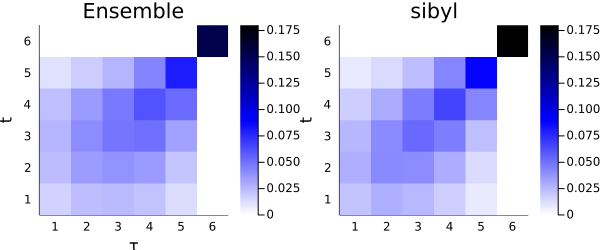

In [123]:
plot_sib = heatmap(sibylmarg2D,c=[:white,:blue,:black],csclxlabel="τ",ylabel="t",title="sibyl") 
plot_ens = heatmap(marg2D,c=[:white,:blue,:black],xlabel="τ",ylabel="t",title="Ensemble")
plot(plot_ens,plot_sib,size=(600,250),clims=(0,0.18))
#savefig("ensemble_VS_sibyl")